In [169]:

import re
import string
import os
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import *
from tensorflow.keras.datasets import imdb
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from tensorflow.keras import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tokenizers import (ByteLevelBPETokenizer,CharBPETokenizer,SentencePieceBPETokenizer,BertWordPieceTokenizer)
from transformers import *
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Embedding, Flatten,Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
display(HTML("<style>.container { width:100% !important; }</style>"))
from sklearn.metrics import confusion_matrix, accuracy_score, auc
import seaborn as sns

In [170]:
Train = pd.read_csv(r'C:\Users\conno\Documents\Kaggle\Tweet Sentiment\train.csv')
Test = pd.read_csv(r'C:\Users\conno\Documents\Kaggle\Tweet Sentiment\test.csv')

In [171]:
#competition is using Jaccard score 
def jaccard(str1, str2): 
    a = set(str(str1).lower().split()) 
    b = set(str(str2).lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))


Sentence_1 = 'Life well spent is life good'
Sentence_2 = 'Life well spent is life good'
Sentence_3 = 'Life is good'

    
print(jaccard(Sentence_1,Sentence_2))
print(jaccard(Sentence_1,Sentence_3))

1.0
0.6


In [172]:
#analyze null data points
print('Train Nulls')
print(Train.isnull().sum())
print('Test Nulls')
print(Test.isnull().sum())

Train Nulls
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
Test Nulls
textID       0
text         0
sentiment    0
dtype: int64


In [173]:
#drop values with nulls
Train.dropna(inplace = True)
Test.dropna(inplace = True)

In [174]:
Train

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


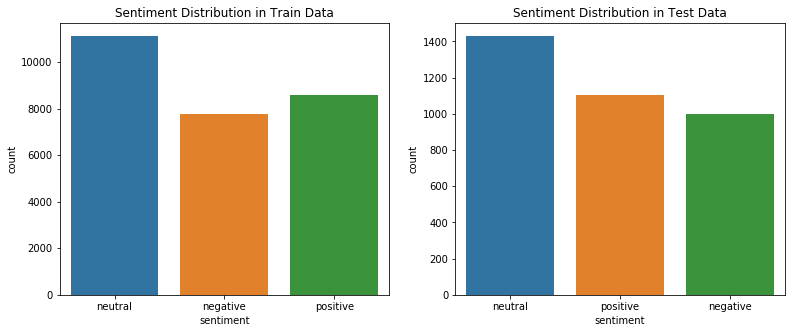

In [175]:
#plot sentiment distributions
plt.figure(figsize = (13,5))
plt.subplot(121)
plt.title('Sentiment Distribution in Train Data')
sns.countplot(Train['sentiment'])
plt.subplot(122)
plt.title('Sentiment Distribution in Test Data')
sns.countplot(Test['sentiment'])


In [176]:
def clean_data(data):
    # Removing extra spaces in the beginning of text
    data = data.strip()
    # Lower the Text
    data = data.lower()
    return data

In [177]:
#apply clean_data
Train['text'] = Train['text'].apply(lambda x: clean_data(x))
Train['selected_text'] = Train['selected_text'].apply(lambda x: clean_data(x))

In [178]:
#count words
Train['num_words_text'] = Train['text'].str.split().apply(lambda x: len(x))
Test['num_words_text'] = Test['text'].str.split().apply(lambda x: len(x))
Train['num_words_selected_text'] = Train['selected_text'].str.split().apply(lambda x: len(x))

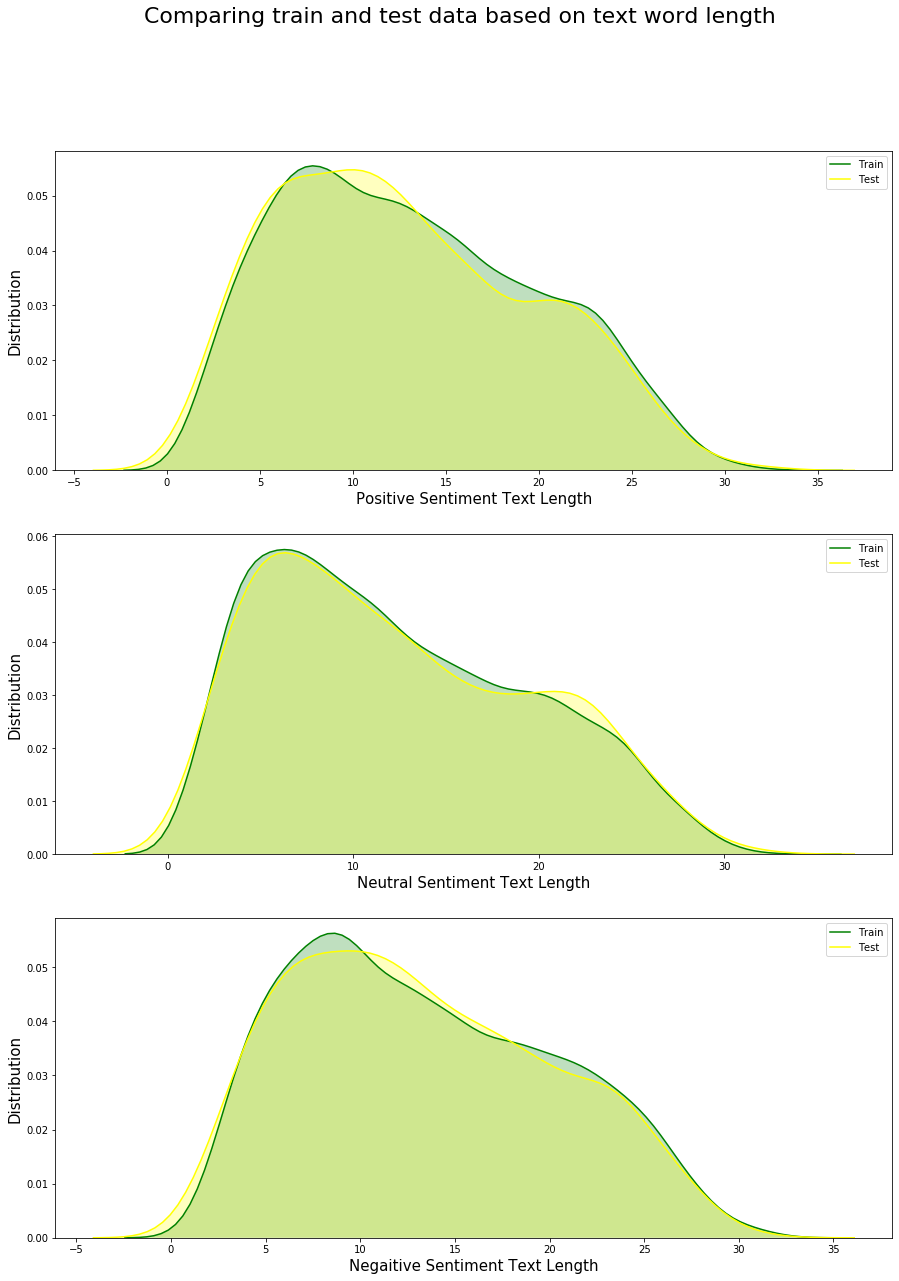

In [179]:
plt.figure(figsize = (15,20))
plt.suptitle('Comparing train and test data based on text word length', fontsize = 22)
plt.subplot(311)
plt.xlabel('Positive Sentiment Text Length', fontsize = 15)
plt.ylabel('Distribution', fontsize = 15)
sns.kdeplot(Train[Train['sentiment']=='positive']['num_words_text'].values, shade = True, color = 'green', label = 'Train')
sns.kdeplot(Test[Test['sentiment']=='positive']['num_words_text'].values, shade = True, color = 'yellow', label = 'Test')
plt.subplot(312)
plt.xlabel('Neutral Sentiment Text Length', fontsize = 15)
plt.ylabel('Distribution', fontsize = 15)
sns.kdeplot(Train[Train['sentiment']=='neutral']['num_words_text'].values, shade = True, color = 'green', label = 'Train')
sns.kdeplot(Test[Test['sentiment']=='neutral']['num_words_text'].values, shade = True, color = 'yellow', label = 'Test')
plt.subplot(313)
plt.xlabel('Negaitive Sentiment Text Length', fontsize = 15)
plt.ylabel('Distribution', fontsize = 15)
sns.kdeplot(Train[Train['sentiment']=='negative']['num_words_text'].values, shade = True, color = 'green', label = 'Train')
sns.kdeplot(Test[Test['sentiment']=='negative']['num_words_text'].values, shade = True, color = 'yellow', label = 'Test')

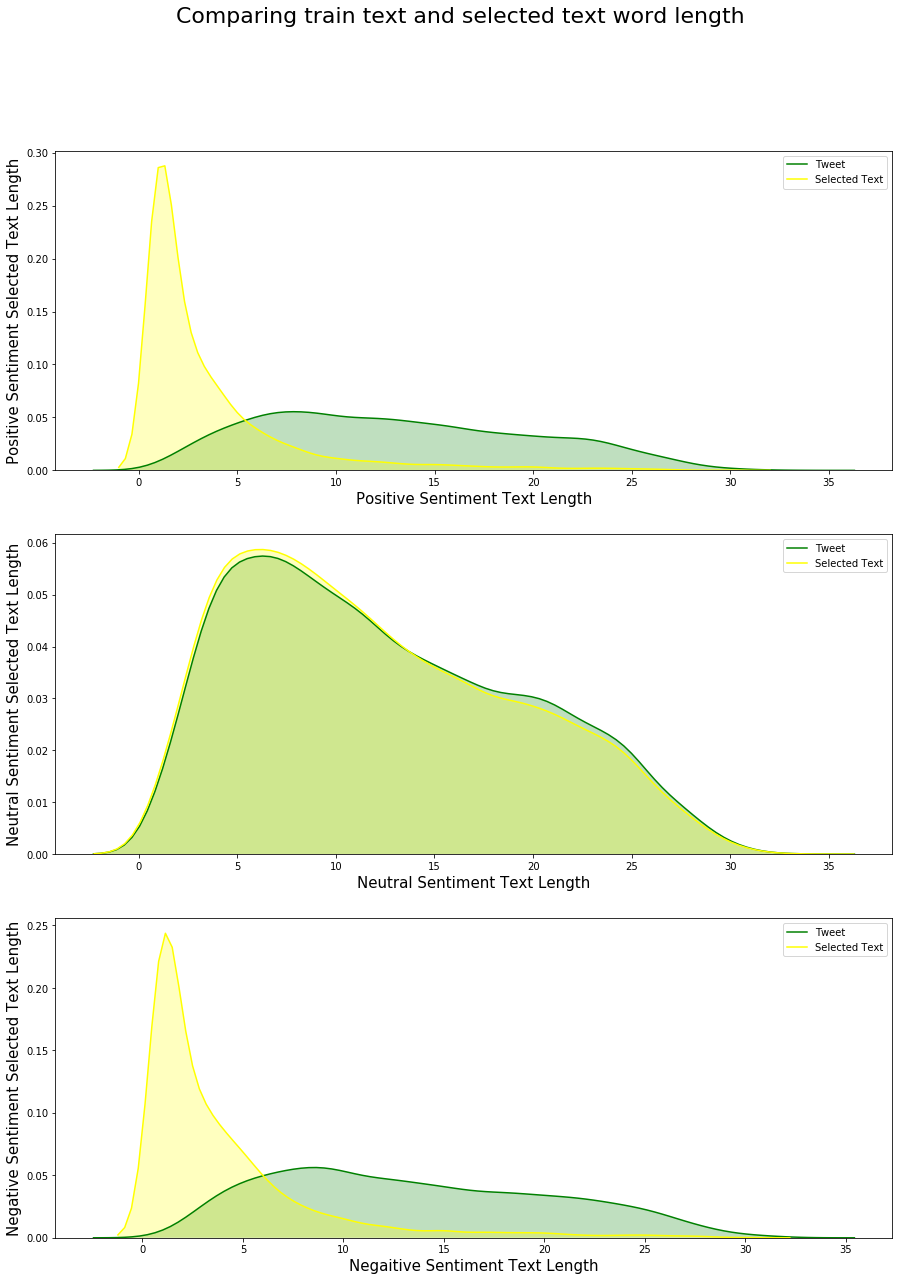

In [180]:
plt.figure(figsize = (15,20))
plt.suptitle('Comparing train text and selected text word length', fontsize = 22)
plt.subplot(311)
plt.xlabel('Positive Sentiment Text Length', fontsize = 15)
plt.ylabel('Positive Sentiment Selected Text Length', fontsize = 15)
sns.kdeplot(Train[Train['sentiment']=='positive']['num_words_text'].values, shade = True, color = 'green', label = 'Tweet')
sns.kdeplot(Train[Train['sentiment']=='positive']['num_words_selected_text'].values, shade = True, color = 'yellow', label = 'Selected Text')
plt.subplot(312)
plt.xlabel('Neutral Sentiment Text Length', fontsize = 15)
plt.ylabel('Neutral Sentiment Selected Text Length', fontsize = 15)
sns.kdeplot(Train[Train['sentiment']=='neutral']['num_words_text'].values, shade = True, color = 'green', label = 'Tweet')
sns.kdeplot(Train[Train['sentiment']=='neutral']['num_words_selected_text'].values, shade = True, color = 'yellow', label = 'Selected Text')
plt.subplot(313)
plt.xlabel('Negaitive Sentiment Text Length', fontsize = 15)
plt.ylabel('Negative Sentiment Selected Text Length', fontsize = 15)
sns.kdeplot(Train[Train['sentiment']=='negative']['num_words_text'].values, shade = True, color = 'green', label = 'Tweet')
sns.kdeplot(Train[Train['sentiment']=='negative']['num_words_selected_text'].values, shade = True, color = 'yellow', label = 'Selected Text')

In [181]:
def punctuation_count(data):
    x = len([w for w in data if w in string.punctuation])
    return x

In [182]:
#count punctuations
Train['punct_count_text'] = Train['text'].apply(lambda x: punctuation_count(x))
Train['punct_count_selected_text'] = Train['selected_text'].apply(lambda x: punctuation_count(x))

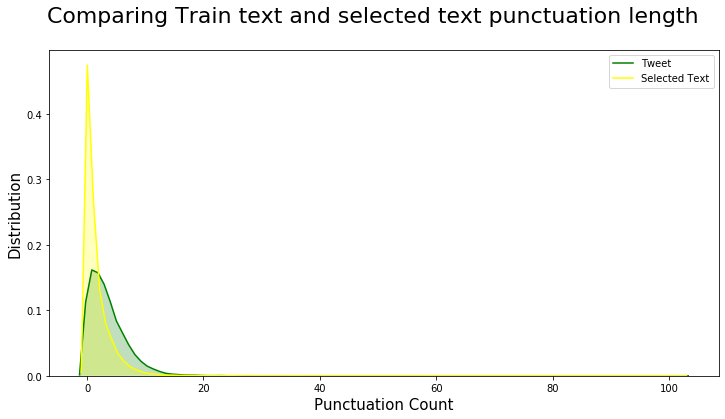

In [183]:
plt.figure(figsize = (12,6))
plt.suptitle('Comparing Train text and selected text punctuation length', fontsize = 22)
plt.xlabel('Punctuation Count', fontsize = 15)
plt.ylabel('Distribution', fontsize = 15)
sns.kdeplot(Train['punct_count_text'].values, shade = True, color = 'green', label = 'Tweet')
sns.kdeplot(Train['punct_count_selected_text'].values, shade = True, color = 'yellow', label = 'Selected Text')

In [184]:
positive_tweet = Train[Train['sentiment']=='positive']
negative_tweet = Train[Train['sentiment']=='negative']
neutral_tweet = Train[Train['sentiment']=='neutral']

In [185]:
def get_top_n_words(corpus, ngram_range = (1,1), n = None):
    vec = CountVectorizer(ngram_range = ngram_range, stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0)
    word_freq = [(word, sum_words[0,idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(word_freq, key = lambda x: x[1], reverse = True)
    return word_freq[:n]

<Figure size 432x288 with 0 Axes>

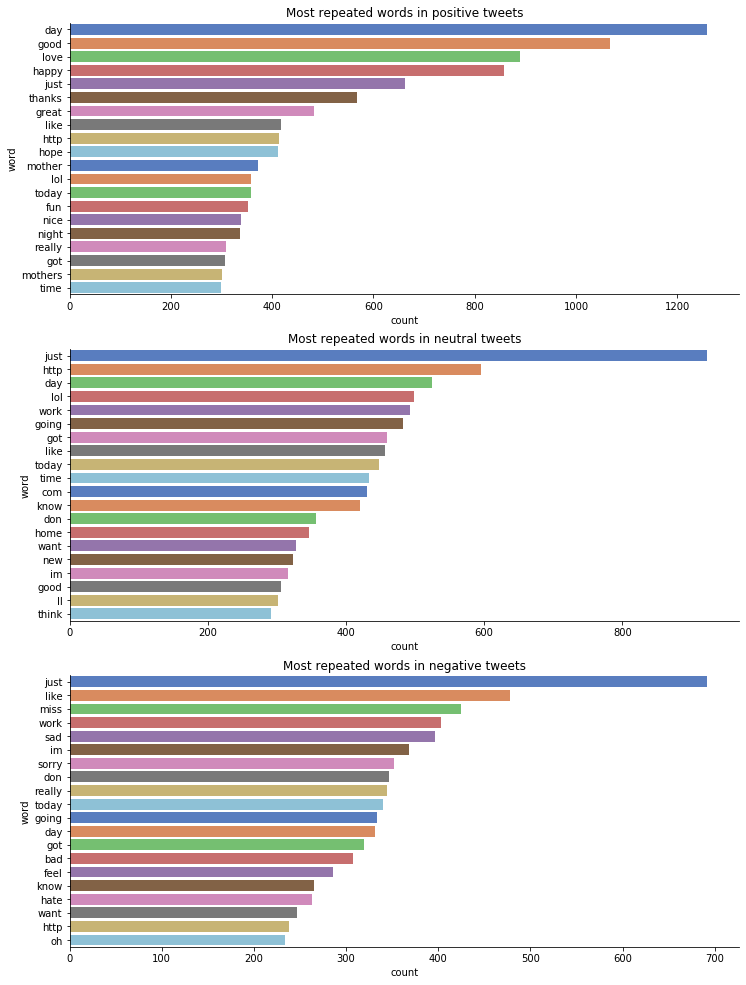

In [186]:
pos_unigram = get_top_n_words(positive_tweet['text'], (1,1), 20)
neutral_unigram = get_top_n_words(neutral_tweet['text'], (1,1), 20)
neg_unigram = get_top_n_words(negative_tweet['text'], (1,1), 20)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neutral_unigram, columns = ['word','count'])
df3 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,17))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1, palette = "muted" )
ax1.set_title('Most repeated words in positive tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2, palette = "muted")
ax2.set_title('Most repeated words in neutral tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df3, orient = 'h',ax = ax3, palette = "muted")
ax3.set_title('Most repeated words in negative tweets')
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.grid(False)

<Figure size 432x288 with 0 Axes>

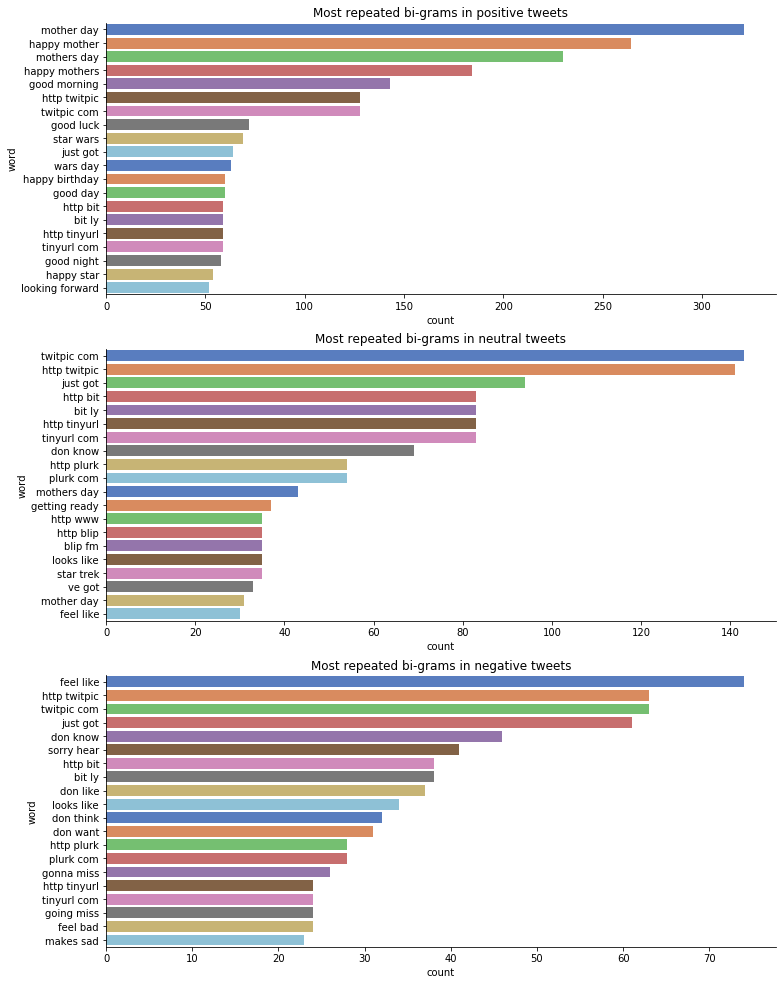

In [187]:
pos_bigram = get_top_n_words(positive_tweet['text'], (2,2), 20)
neutral_bigram = get_top_n_words(neutral_tweet['text'], (2,2), 20)
neg_bigram = get_top_n_words(negative_tweet['text'], (2,2), 20)

df1 = pd.DataFrame(pos_bigram, columns = ['word','count'])
df2 = pd.DataFrame(neutral_bigram, columns = ['word','count'])
df3 = pd.DataFrame(neg_bigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,17))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1, palette = "muted")
ax1.set_title('Most repeated bi-grams in positive tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2, palette = "muted")
ax2.set_title('Most repeated bi-grams in neutral tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df3, orient = 'h',ax = ax3, palette = "muted")
ax3.set_title('Most repeated bi-grams in negative tweets')
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.grid(False)

<Figure size 432x288 with 0 Axes>

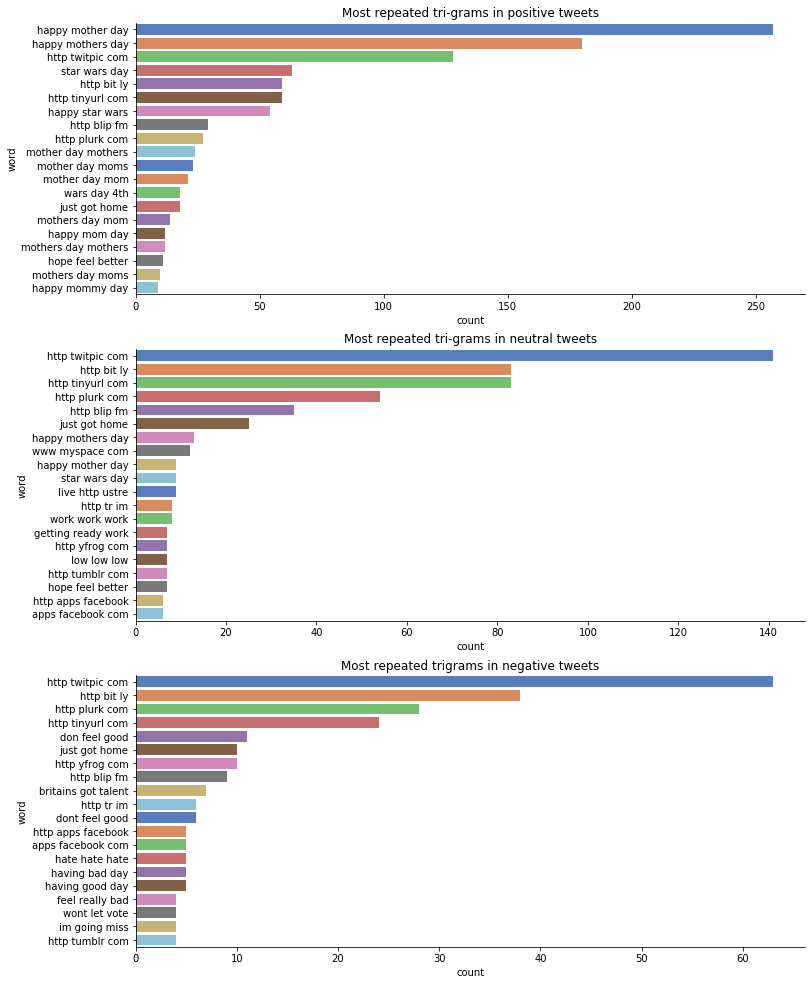

In [188]:
pos_trigram = get_top_n_words(positive_tweet['text'], (3,3), 20)
neutral_trigram = get_top_n_words(neutral_tweet['text'], (3,3), 20)
neg_trigram = get_top_n_words(negative_tweet['text'], (3,3), 20)

df1 = pd.DataFrame(pos_trigram, columns = ['word','count'])
df2 = pd.DataFrame(neutral_trigram, columns = ['word','count'])
df3 = pd.DataFrame(neg_trigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,17))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1, palette = "muted")
ax1.set_title('Most repeated tri-grams in positive tweets')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2, palette = "muted")
ax2.set_title('Most repeated tri-grams in neutral tweets')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df3, orient = 'h',ax = ax3, palette = "muted")
ax3.set_title('Most repeated trigrams in negative tweets')
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.grid(False)

<Figure size 432x288 with 0 Axes>

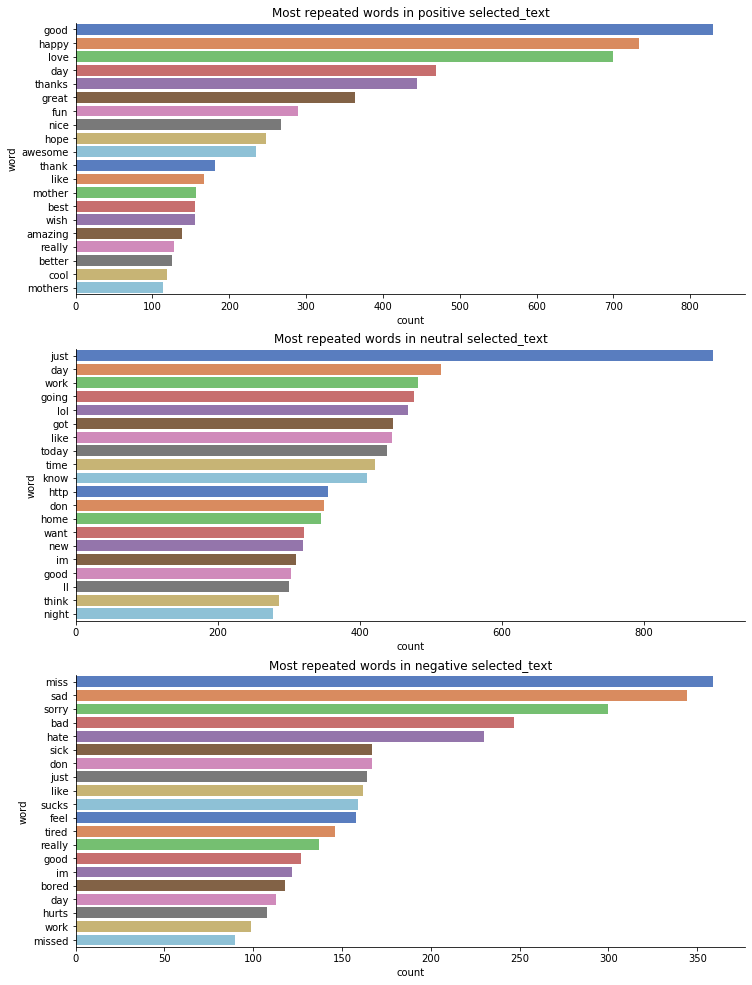

In [189]:
pos_unigram = get_top_n_words(positive_tweet['selected_text'], (1,1), 20)
neutral_unigram = get_top_n_words(neutral_tweet['selected_text'], (1,1), 20)
neg_unigram = get_top_n_words(negative_tweet['selected_text'], (1,1), 20)

df1 = pd.DataFrame(pos_unigram, columns = ['word','count'])
df2 = pd.DataFrame(neutral_unigram, columns = ['word','count'])
df3 = pd.DataFrame(neg_unigram, columns = ['word','count'])

plt.tight_layout()
fig,(ax1,ax2,ax3)=plt.subplots(3,1,figsize=(12,17))
sns.barplot(x = 'count' , y = 'word', data = df1, orient = 'h',ax = ax1, palette = "muted")
ax1.set_title('Most repeated words in positive selected_text')
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
ax1.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df2, orient = 'h',ax = ax2, palette = "muted")
ax2.set_title('Most repeated words in neutral selected_text')
ax2.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.grid(False)
sns.barplot(x = 'count' , y = 'word', data = df3, orient = 'h',ax = ax3, palette = "muted")
ax3.set_title('Most repeated words in negative selected_text')
ax3.spines["right"].set_visible(False)
ax3.spines["top"].set_visible(False)
ax3.grid(False)

In [190]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') 

# Save the loaded tokenizer locally
save_path = r'C:/Users/conno/Documents/Kaggle/working/distilbert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

# Reload it with the huggingface tokenizers library
quick_tokenizer = BertWordPieceTokenizer('C:/Users/conno/Documents/Kaggle/working/distilbert_base_uncased/vocab.txt', lowercase=True)
quick_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [191]:
#https://www.kaggle.com/rftexas/text-only-bert-keras
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [192]:
x_train = fast_encode(Train.text.astype(str), quick_tokenizer, maxlen=128)
x_test = fast_encode(Test.text.astype(str),quick_tokenizer,maxlen=128)

100%|█████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 181.78it/s]


In [193]:
transformer_layer = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [194]:
def dev_targets(df):
    df['t_text'] = df['text'].apply(lambda x: tokenizer.tokenize(str(x)))
    df['t_selected_text'] = df['selected_text'].apply(lambda x: tokenizer.tokenize(str(x)))
    def func(row):
        x,y = row['t_text'],row['t_selected_text'][:]
        for offset in range(len(x)):
            d = dict(zip(x[offset:],y))
            #when k = v that means we found the offset
            check = [k==v for k,v in d.items()]
            if all(check)== True:
                break 
        return [0]*offset + [1]*len(y) + [0]* (len(x)-offset-len(y))
    df['targets'] = df.apply(func,axis=1)
    return df

Train = dev_targets(Train)

print('MAX_SEQ_LENGT', max(Train['t_text'].apply(len)))
print('MAX_TAR_LENGTH',max(Train['targets'].apply(len)))
MAX_TAR_LEN=108

MAX_SEQ_LENGT 108
MAX_TAR_LENGTH 108


In [195]:
Train['targets'] = Train['targets'].apply(lambda x :x + [0] * (MAX_TAR_LEN-len(x)))
targets=np.asarray(Train['targets'].values.tolist())

In [196]:
lb=LabelEncoder()
sentence_train=lb.fit_transform(Train['sentiment'])
sentence_test=lb.fit_transform(Test['sentiment'])

In [197]:
print('x_train shape',x_train.shape)
print('x_test shape',x_test.shape)
print('sentence_train shape',sentence_train.shape)

x_train shape (27480, 128)
x_test shape (3534, 128)
sentence_train shape (27480,)


In [198]:
Train,val = train_test_split(Train,test_size = .2, random_state = 42)
#x_train, x_val, y_train, y_val = train_test_split(x_train, targets, test_size=0.2, random_state=42)
#sentence_train,sentence_val = train_test_split(sentence_train, test_size=0.2, random_state=42)
#targets, val_targets = train_test_split(targets, test_size=0.2, random_state=42)

In [199]:
print('x_train shape',x_train.shape)
print('y_train shape',y_train.shape)
print('x_val shape',x_val.shape)
print('y_val shape',y_val.shape)
print('sentence_train shape',sentence_train.shape)
print('sentence_val shape',sentence_val.shape)
print('targets shape',targets.shape)
print('val_targets shape',val_targets.shape)


x_train shape (27480, 128)
y_train shape (21984, 108)
x_val shape (5496, 128)
y_val shape (5496, 108)
sentence_train shape (27480,)
sentence_val shape (5496,)
targets shape (27480, 108)
val_targets shape (5496, 108)


In [284]:
embedding_matrix=transformer_layer.weights[0].numpy()

model = Sequential()
model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1],weights=[embedding_matrix],trainable=False,name = 'BERT_Embeddings'))
model.add(LSTM(250, return_sequences=True,name='lstm_1', dropout = .2))
model.add(LSTM(150, return_sequences=False,name='lstm_2', dropout = .2))


model.add(Dense(10,activation='relu'))
model.add(Dense(MAX_TAR_LEN,activation='sigmoid'))


In [285]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BERT_Embeddings (Embedding)  (None, None, 768)         23440896  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 250)         1019000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150)               240600    
_________________________________________________________________
dense_20 (Dense)             (None, 10)                1510      
_________________________________________________________________
dense_21 (Dense)             (None, 108)               1188      
Total params: 24,703,194
Trainable params: 1,262,298
Non-trainable params: 23,440,896
_________________________________________________________________


In [286]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit([x_train,sentence_train],targets, epochs=30)

Epoch 1/30
859/859 [==============================] - 24s 28ms/step - loss: 0.2108 - accuracy: 0.2368
Epoch 2/30
859/859 [==============================] - 24s 28ms/step - loss: 0.1807 - accuracy: 0.2770
Epoch 3/30
859/859 [==============================] - 25s 29ms/step - loss: 0.1806 - accuracy: 0.2649
Epoch 4/30
859/859 [==============================] - 24s 28ms/step - loss: 0.1806 - accuracy: 0.2741
Epoch 5/30
859/859 [==============================] - 24s 28ms/step - loss: 0.1806 - accuracy: 0.2876
Epoch 6/30
859/859 [==============================] - 24s 29ms/step - loss: 0.1805 - accuracy: 0.3362
Epoch 7/30
859/859 [==============================] - 25s 29ms/step - loss: 0.1805 - accuracy: 0.32650s -
Epoch 8/30
859/859 [==============================] - 24s 29ms/step - loss: 0.1804 - accuracy: 0.3136
Epoch 9/30
859/859 [==============================] - 24s 28ms/step - loss: 0.1805 - accuracy: 0.3211
Epoch 10/30
859/859 [==============================] - 24s 28ms/step - loss: 0

In [287]:
predictions=model.predict([x_val,sentence_val])

In [288]:
def token_2_text(sub,predictions):
    preds=[]
    for i,row in enumerate(sub['text']):

        text,target=row.lower(),predictions[i].tolist()
        target=np.round(target).tolist()
        try:
            start,end=target.index(1),target[::-1].index(1)
            text_list=tokenizer.tokenize(text)
            text_list=text_list+((MAX_TAR_LEN-len(text_list))*['pad'])
            start_w,end_w=text_list[start],text_list[-end]
            start=text.find(start_w.replace("#",'',1))    ## remove # to match substring
            end=text.find(end_w.replace("#",''),start)
            pred=text[start:end]
        except:
            pred=text
        
        preds.append(pred)
        
    return preds

In [289]:
Train

,textID,text,selected_text,sentiment,num_words_text,num_words_selected_text,punct_count_text,punct_count_selected_text,t_text,t_selected_text,targets
21209,306d7b314b,"oh, he`s hilarious. i`m just commenting on the...",hilarious.,positive,14,1,6,1,"[oh, ,, he, `, s, hilarious, ., i, `, m, just,...","[hilarious, .]","[0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
18265,ce54016d40,"thanks for trying i was hoping bud trillin, ...","thanks for trying i was hoping bud trillin, ...",positive,23,23,2,1,"[thanks, for, trying, i, was, hoping, bud, tri...","[thanks, for, trying, i, was, hoping, bud, tri...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
9684,5162aa68ce,after show at our house rocked! saying goodbye...,after show at our house rocked! saying goodbye...,neutral,9,9,1,1,"[after, show, at, our, house, rocked, !, sayin...","[after, show, at, our, house, rocked, !, sayin...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
9689,84bcf86d43,up at 4:30am west coast time..gettin ready to ...,soooo excited to go back to my two fav boyzzzz...,positive,25,13,5,0,"[up, at, 4, :, 30, ##am, west, coast, time, .,...","[soo, ##oo, excited, to, go, back, to, my, two...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
22728,ea91e5a7ab,my computer is so slooowww this morning. i th...,my computer is so slooowww this morning. i th...,neutral,22,22,3,3,"[my, computer, is, so, sl, ##oo, ##ow, ##w, ##...","[my, computer, is, so, sl, ##oo, ##ow, ##w, ##...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...
21576,0092c21828,feels like warm things,feels like warm things,neutral,4,4,0,0,"[feels, like, warm, things]","[feels, like, warm, things]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5391,e2ae8ec389,my best friend is in vegas without me,my best friend is in vegas without me,neutral,8,8,0,0,"[my, best, friend, is, in, vegas, without, me]","[my, best, friend, is, in, vegas, without, me]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
861,35210988be,http://twitpic.com/4jken - fire and urban at r...,http://twitpic.com/4jken - fire and urban at r...,neutral,8,8,6,6,"[http, :, /, /, t, ##wi, ##tp, ##ic, ., com, /...","[http, :, /, /, t, ##wi, ##tp, ##ic, ., com, /...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
15796,1e12b8b504,a+ for effort though http://bit.ly/mco5v,effort,positive,5,1,6,0,"[a, +, for, effort, though, http, :, /, /, bit...",[effort],"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [290]:
predicted_text=token_2_text(val,predictions)

In [291]:
len(predicted_text)

5496

In [292]:
sub=pd.read_csv(r"C:\Users\conno\Documents\Kaggle\Tweet Sentiment\sample_submission.csv")
sub['selected_text']=prediction_text 
sub.to_csv(r'C:\Users\conno\Documents\Kaggle\Tweet Sentiment\submission.csv',index=False) 
sub.head()


,textID,selected_text
0,f87dea47db,last session of the day http:
1,96d74cb729,shanghai is also really exciting (precisely
2,eee518ae67,recession hit veronique branquin
3,01082688c6,happy bday
4,33987a8ee5,http://twitp


In [293]:
val['pred'] = predicted_text

C:\Users\conno\.conda\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [294]:
val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5496 entries, 1589 to 24839
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   textID                     5496 non-null   object 
 1   text                       5496 non-null   object 
 2   selected_text              5496 non-null   object 
 3   sentiment                  5496 non-null   object 
 4   num_words_text             5496 non-null   int64  
 5   num_words_selected_text    5496 non-null   int64  
 6   punct_count_text           5496 non-null   int64  
 7   punct_count_selected_text  5496 non-null   int64  
 8   t_text                     5496 non-null   object 
 9   t_selected_text            5496 non-null   object 
 10  targets                    5496 non-null   object 
 11  pred                       5496 non-null   object 
 12  score                      5496 non-null   float64
dtypes: float64(1), int64(4), object(8)
memory us

In [295]:
val['score'] = val.apply(lambda row: jaccard(row['selected_text'], row['pred']), axis=1)

C:\Users\conno\.conda\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [296]:
pd.options.display.max_rows = 55
val.sort_values(by = 'score',ascending = False)

,textID,text,selected_text,sentiment,num_words_text,num_words_selected_text,punct_count_text,punct_count_selected_text,t_text,t_selected_text,targets,pred,score
9357,2d9629f7d3,thats soooo pretty. mine havnt flowered for years,thats soooo pretty.,positive,8,3,1,1,"[that, ##s, soo, ##oo, pretty, ., mine, ha, ##...","[that, ##s, soo, ##oo, pretty, .]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",thats soooo pretty.,1.0
19984,2bdd1a5262,"not making good time, **** chicago traffic - ...","not making good time,",negative,10,4,12,1,"[not, making, good, time, ,, *, *, *, *, chica...","[not, making, good, time, ,]","[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","not making good time,",1.0
7610,18123152ff,noooooooooo my parrents found my stash,noooooooooo,negative,6,1,0,0,"[no, ##oo, ##oo, ##oo, ##oo, ##o, my, par, ##r...","[no, ##oo, ##oo, ##oo, ##oo, ##o]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",noooooooooo,1.0
9953,951f82ea22,hates typing on a mac. wishing that i`ll be do...,hates typing on a mac.,negative,15,5,3,1,"[hates, typing, on, a, mac, ., wishing, that, ...","[hates, typing, on, a, mac, .]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",hates typing on a mac.,1.0
13064,272ec1154a,"ya know why today sucks? its been raining, we ...",ya know why today sucks?,negative,24,5,7,1,"[ya, know, why, today, sucks, ?, its, been, ra...","[ya, know, why, today, sucks, ?]","[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",ya know why today sucks?,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18834,4435584f59,richelle mead - succubus blues-fabulous read! ...,"! very entertaining, lots of fun and interesti...",positive,16,11,8,6,"[rich, ##elle, mead, -, su, ##cc, ##ub, ##us, ...","[!, very, entertaining, ,, lots, of, fun, and,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...",richelle mead - succ,0.0
14919,e5b86c0cac,"made it into leadership, buttt i`m still not h...",not happy!,negative,18,2,4,1,"[made, it, into, leadership, ,, butt, ##t, i, ...","[not, happy, !]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...",made i,0.0
12969,df409d4a7f,listening to: sweet talk 101 - cute is what we...,miss,negative,23,1,7,0,"[listening, to, :, sweet, talk, 101, -, cute, ...",[miss],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",listening to: sweet talk 101,0.0
5108,f651d6efda,good morning to you. hope you have a nice prod...,nice productive day,positive,11,3,1,0,"[good, morning, to, you, ., hope, you, have, a...","[nice, productive, day]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...",good morning to,0.0


In [297]:
val[['score','sentiment']].groupby('sentiment').mean()

,score
sentiment,
negative,0.186563
neutral,0.368895
positive,0.191557


sentiment
negative    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
neutral     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
positive    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

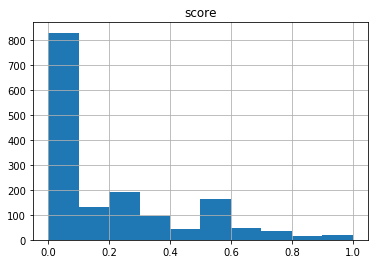

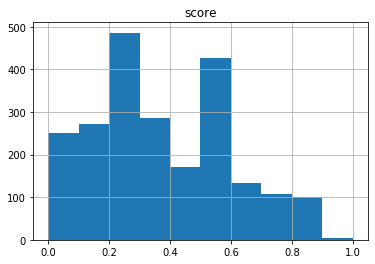

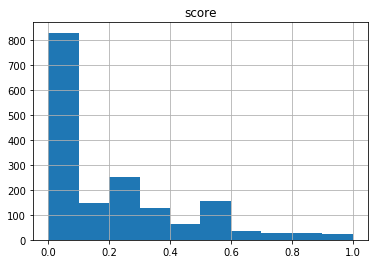

In [298]:
val[['score','sentiment']].groupby('sentiment').hist()

In [299]:
val.to_excel(r'C:\Users\conno\Documents\Kaggle\Tweet Sentiment\validation_predictions.xlsx')